# **04 - Model Inference**

### **Imports & Load Model**

In [1]:
# Configure Openslide 
OPENSLIDE_PATH = r'C:\Users\johng\Downloads\openslide-win64-20231011\bin'

import os
if hasattr(os, 'add_dll_directory'):
    # Windows
    with os.add_dll_directory(OPENSLIDE_PATH):
        import openslide
else:
    import openslide

In [2]:
import os
from os import listdir
from os.path import isfile, join
import sys
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import matplotlib.pyplot as plt 
import PIL
import openslide
import skimage.io
from tqdm.notebook import tqdm
import zipfile
import cv2 as cv
import torch
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import copy
from PIL import Image
import glob
import random
import torch
from torchvision import transforms
import re
from sklearn.metrics import roc_curve, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix

from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import image_dataset_from_directory

from torchvision import datasets, models, transforms

C:\Users\johng\anaconda3\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [16]:
model = torch.load('models/model.pth')
model.to('cpu')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### **Run model on whole slide image and applies cancer mask** 
#### Create function that breaks a slide into tiles, runs the model on each tile and applies mask, stitches together tiles, then outputs whole slide image with mask overlayed

In [9]:
# PRIOR INPUTS
# Location of the files
data_dir = 'data/train_images'
mask_dir = 'data/train_label_masks/'
out_dir = 'data/tiled_images/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
# Location of training labels
samples = pd.read_csv('train.csv')

# Creates a numpy array from a selected tile in a slide
def tile_array(slide, tile, tile_size, level):
    region = np.copy(np.asarray(slide.read_region((tile['xloc']*(4**level),tile['yloc']*(4**level)), level, (tile_size,tile_size)))) # The position is wrt. level 0, so must convert to level 0 coordinates by multiplying by the downsampling factor.
    if tile['required_padding']:
        region[region==0] = 255     
    return region

def get_tile_locations_from_slide(slide, tile_size, N, level):
    tiles = []
    required_padding = False
    xlocs, ylocs = np.arange(0, slide.level_dimensions[level][0], tile_size), np.arange(0, slide.level_dimensions[level][1], tile_size) # Get the coordinates of the top left corners of the tiles.
    for x_i, xloc in enumerate(xlocs):
        for y_i, yloc in enumerate(ylocs):
            region = np.copy(slide.read_region((xloc*(4**level),yloc*(4**level)), level, (tile_size,tile_size))) # The position is wrt. level 0, so must convert to level 0 coordinates by multiplying by the downsampling factor.
            region_arr = np.asarray(region)[:,:,:3] # Ignore the alpha channel
            if xloc+tile_size > slide.level_dimensions[level][0] or yloc+tile_size > slide.level_dimensions[level][1]: # if the tile goes out of bounds
                region_arr[region_arr==0] = 255
                required_padding = True
            pixel_sum = region_arr.sum()
            tiles.append({'xloc': xloc, 'yloc': yloc, 'pixel_sum': pixel_sum, 'required_padding': required_padding}) # store top left corner location and the tile's pixel_sum
            required_padding = False
    sorted_tiles = sorted(tiles, key= lambda d: d['pixel_sum']) # Sort tiles based on their pixel_sum field
    sorted_tiles = sorted_tiles[:N] # Get top N tiles
    return sorted_tiles

# Returns if a region of the mask slide contains cancerous tissue or not
def classify_as_cancerous(region, provider):
    if provider == 'karolinska':
        if 2 in region:
            return 'cancer'
        else:
            return 'noncancer'
    elif provider == 'radboud':
        if 3 in region or 4 in region or 5 in region:
            return 'cancer'
        else:
            return 'noncancer'
    else:
        raise Exception("Provider must be either karolinska or radboud")
        
def save_img(img, filename, folder):
    if not os.path.exists(folder):
        os.makedirs(folder)
    print(f'Saving to: {os.path.join(folder, filename+".png")}')
    cv.imwrite(os.path.join(folder, filename+".png"), img)

pxsize = 227 # size of the images to be used by the network, can be center-cropped below 256

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(pxsize),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [10]:
def make_tiles_from_image(indx, tile_size, level, output_folder=None):
    sample = samples.iloc[int(indx)]
    image_id = sample.loc['image_id']
    data_provider = sample.loc['data_provider']
    slide = openslide.OpenSlide(os.path.join(data_dir, image_id+'.tiff'))
    mask = openslide.OpenSlide(os.path.join(mask_dir, image_id+'_mask.tiff'))
    tiles = get_tile_locations_from_slide(slide, tile_size=256, N=36, level=1)
    
    if output_folder == None:
        output_folder = 'data/tiled_images/tiles/' + image_id
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        
    for tile in tiles:
        tile_coordinate = f'''({str(tile['xloc'])}, {str(tile['yloc'])})'''
        image_tile_array = tile_array(slide, tile, tile_size, level)
        mask_tile_array = tile_array(mask, tile, tile_size, level)
        label = classify_as_cancerous(mask_tile_array, data_provider)
        filename = f'{image_id}_{tile_coordinate}_{label}'
        save_img(image_tile_array, filename, output_folder)
    
    return os.path.join(data_dir, image_id+'.tiff'), output_folder

In [34]:
# Sample new slide, generate tiles and put them in a folder named as the original image
# Then, apply ResNet50 model to each tile

# Choose any image that in which you want to overlap the cancer probability masks
indx = 200 # can choose any from 0 to 10,616
tile_size = 256 # tile size
level = 1 # level
pxsize = 227
img_path, tiles_path = make_tiles_from_image(indx, tile_size, level, output_folder=None) # this will create a subfolder inside the specified output_folder containing the tiles 
tiles = glob.glob(os.path.join(tiles_path, '*cancer.png')) 
labels = [int('noncancer' not in tile) for tile in tiles]

X = preprocess(Image.open(tiles[0]).convert('RGB')).reshape(1,3,pxsize,pxsize) # convert to RGB to drop alpha channel of png 
for tile in tiles[1:]:
    X = torch.cat((preprocess(Image.open(tile).convert('RGB')).reshape(1,3,pxsize,pxsize), X), axis=0)

Y = torch.Tensor(labels).type(torch.LongTensor)
probs = nn.Softmax()(model(X))[:,1].detach().numpy()
slide = openslide.OpenSlide(img_path)

Saving to: data/tiled_images/tiles/0550b23f29085f41b10d165a46ad4371\0550b23f29085f41b10d165a46ad4371_(2816, 256)_cancer.png
Saving to: data/tiled_images/tiles/0550b23f29085f41b10d165a46ad4371\0550b23f29085f41b10d165a46ad4371_(2560, 256)_cancer.png
Saving to: data/tiled_images/tiles/0550b23f29085f41b10d165a46ad4371\0550b23f29085f41b10d165a46ad4371_(1792, 256)_cancer.png
Saving to: data/tiled_images/tiles/0550b23f29085f41b10d165a46ad4371\0550b23f29085f41b10d165a46ad4371_(1536, 256)_cancer.png
Saving to: data/tiled_images/tiles/0550b23f29085f41b10d165a46ad4371\0550b23f29085f41b10d165a46ad4371_(3072, 256)_cancer.png
Saving to: data/tiled_images/tiles/0550b23f29085f41b10d165a46ad4371\0550b23f29085f41b10d165a46ad4371_(768, 256)_cancer.png
Saving to: data/tiled_images/tiles/0550b23f29085f41b10d165a46ad4371\0550b23f29085f41b10d165a46ad4371_(1024, 256)_cancer.png
Saving to: data/tiled_images/tiles/0550b23f29085f41b10d165a46ad4371\0550b23f29085f41b10d165a46ad4371_(256, 512)_cancer.png
Saving to:

C:\Users\johng\AppData\Local\Temp\ipykernel_19492\3981436718.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = nn.Softmax()(model(X))[:,1].detach().numpy()


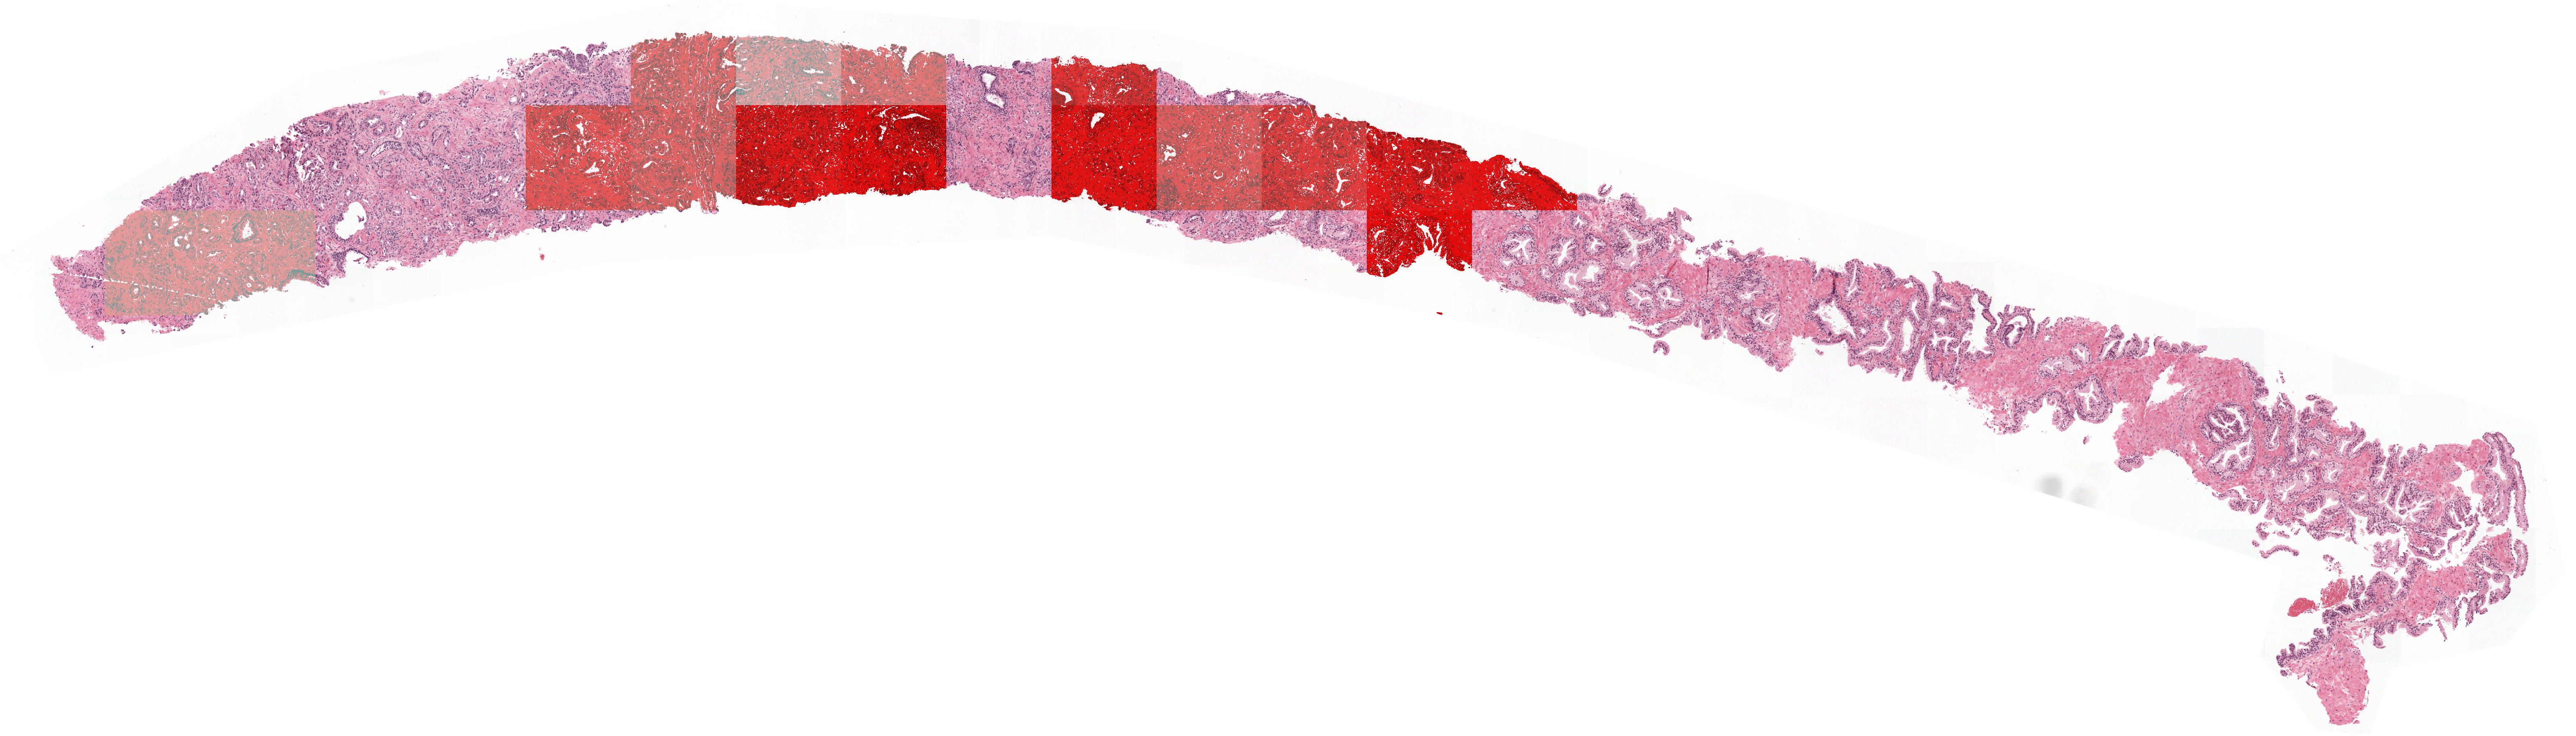

In [47]:
# Overlap red mask
content = np.asarray(slide.read_region((0,0), 1, slide.level_dimensions[1])).copy()

for i, tile in enumerate(tiles):
    x, y = [int(w) for w in re.findall(r'\d+', tile.split("_")[2])]
    detect_white = np.sum(content[y:(y+tile_size),x:(x+tile_size),:], axis=2) < 900
    if probs[i] > 0.2:
        content[y:(y+tile_size),x:(x+tile_size),1] = (1-detect_white)*content[y:(y+tile_size),x:(x+tile_size),1] + detect_white*(1-probs[i])*255
        content[y:(y+tile_size),x:(x+tile_size),2] = (1-detect_white)*content[y:(y+tile_size),x:(x+tile_size),2] + detect_white*(1-probs[i])*255

content_red = content.copy()
img = Image.fromarray(content)
img.save('images/slide_mask.png')
img